# Description

This notebook will allow the user to perform a quick normalization:
    - by selecting 1 or a set of Open Beam (OBs) files
    or
    - by using the first file loaded
    
Quick profile plot will also be available

# Python Import

In [8]:
try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import sys
import glob
import os

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import widgets

import config_handler
import gui_widgets
import file_handler

!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
%gui qt

# Normalization

## Select Normalization Type

In [10]:
list_algo = ['OB', 'First Image Loaded']
algo = widgets.Dropdown(options=list_algo,
                       description='Select Normalization Type')
algo

In [16]:
default_folder = config_handler.load_config(key = 'default_folder')
if sys.platform == 'linux':
        if default_folder == '':
            default_folder = '/HFIR/CG1DImaging/IPTS_17981/'
else:
    default_folder = '.'

if algo.value == 'OB':
    default_ob_folder = config_handler.load_config(key = 'ob_folder')
    if default_ob_folder == '':
        default_ob_folder = default_folder
    ob_files = gui_widgets.gui_tiff(dir = default_ob_folder,
                                   message = 'Select OB Files ...')

    if sys.platform == 'linux':
        ob_files = ob_files[0]  
        
    if not ob_files == []:
        path = os.path.dirname(ob_files[0])
        config_handler.save_config(key='ob_folder', value=path)

        #import images
        w = widgets.IntProgress()
        w.max = len(ob_files)
        display(w)
        
        mean_ob = []
        for _index, _ob_file in enumerate(ob_files):
            _ob_data = file_handler.load_data(_ob_file)
            mean_ob.append(_ob_data)
            w.value = _index + 1

        normalization_data = np.mean(mean_ob, axis=0)

## Select and Load Data Files

In [17]:
default_data_folder = config_handler.load_config(key = 'data_folder')
if default_data_folder == '':
    default_data_folder = default_folder
data_folder = gui_widgets.gui_dname(dir = default_data_folder,
                                   message = 'Select Data Folder ...')

list_data = glob.glob(data_folder + '/*.tif*')
if not list_data == []:
    path = os.path.dirname(list_data[0])
    config_handler.save_config(key='data_folder', value=path)

    #import images
    w = widgets.IntProgress()
    w.max = len(list_data)
    display(w)

    data =[]
    for _index, _file in enumerate(list_data):
        _image = file_handler.load_data(_file)
        data.append(_image)
        w.value = _index+1
        
if algo.value == 'First Image Loaded':
    normalization_data = data[0]

## Perform Normalization and Display Data

### Normalization

In [18]:
 #import images
w = widgets.IntProgress()
w.max = len(list_data)
display(w)

normalized_data = []
for _index, _data in enumerate(data):
    _norm = _data / normalization_data
    normalized_data.append(_norm)
    
    w.value = _index + 1

### Display Data and Select Intensity Range

[0.0, 4.4]

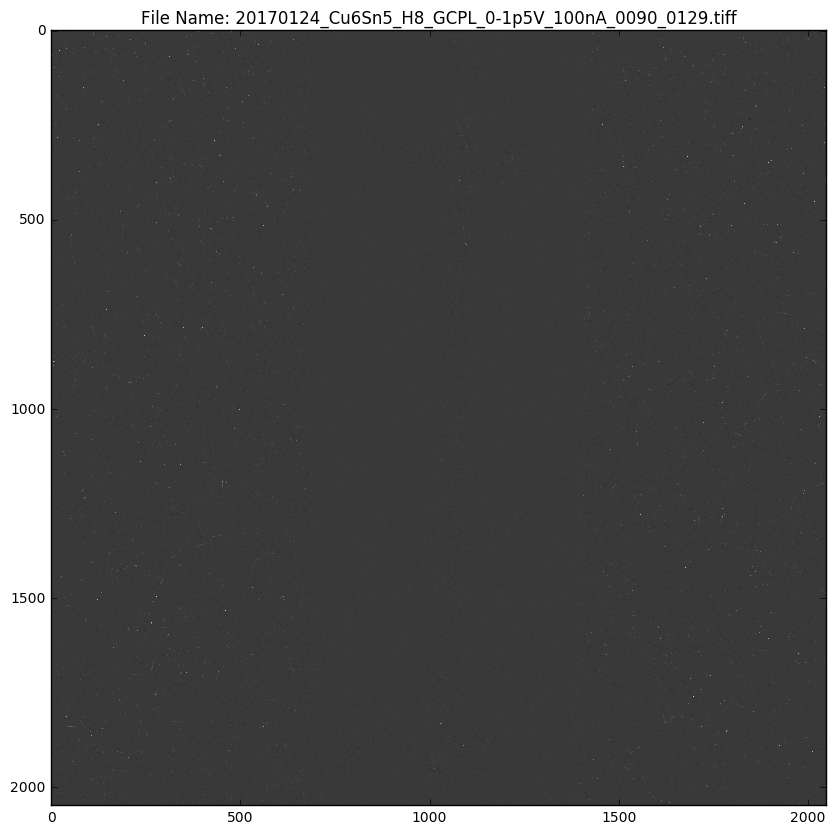

In [19]:
min_counts = config_handler.load_config(key='norm_min_counts')
if min_counts == '':
    min_counts = 0

max_counts = config_handler.load_config(key='norm_max_counts')
if max_counts == '':
    max_counts = 10

def plot_images(file_index, min_counts, max_counts):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(normalized_data[file_index],
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    ax_img.set_title("File Name: {}".format(os.path.basename(list_data[file_index])))
    
    return [min_counts, max_counts]
    
preview = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  min_counts = widgets.FloatSlider(min=0,
                                                max=10,
                                                value=min_counts),
                  max_counts = widgets.FloatSlider(min=0,
                                                 max=10,
                                                 value=max_counts),
                                                 )

### Select Zoom Data

[1, 2047, 852, 1598]

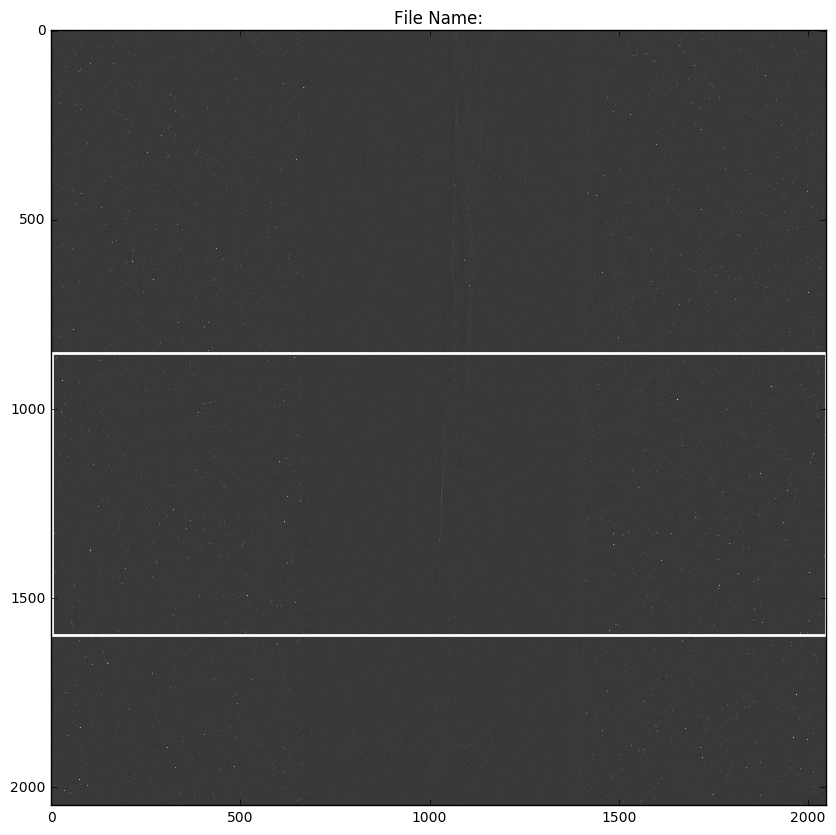

In [20]:
[height, width] = np.shape(normalized_data[0])

[min_counts, max_counts] = preview.widget.result
config_handler.save_config(key='norm_min_counts', value=min_counts)
config_handler.save_config(key='norm_max_counts', value=max_counts)

left = config_handler.load_config(key='norm_zoom_left')
if left == '':
    left = 1
right = config_handler.load_config(key='norm_zoom_right')
if right == '':
    right = width

top = config_handler.load_config(key='norm_zoom_top')
if top == '':
    top = 0

bottom = config_handler.load_config(key='norm_zoom_bottom')
if bottom == '':
    bottom = height

def plot_images(file_index, left, right, top, bottom):
    
    _norm = normalized_data[file_index]
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(_norm,
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    ax_img.set_title("File Name:".format(list_data[file_index]))
    
    _rectangle = patches.Rectangle((left, top),
                                  right-left,
                                  bottom-top,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [left, right, top, bottom]
    
zoom = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"),
                  left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=1,
                                            description='Left'),
                  right = widgets.IntSlider(min=0,
                                           max=width,
                                           value=width-1,
                                           step=1,
                                           description='Right'),
                  top = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=1,
                                            description='Top'),
                   bottom = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=height-1,
                                            description='Bottom'))

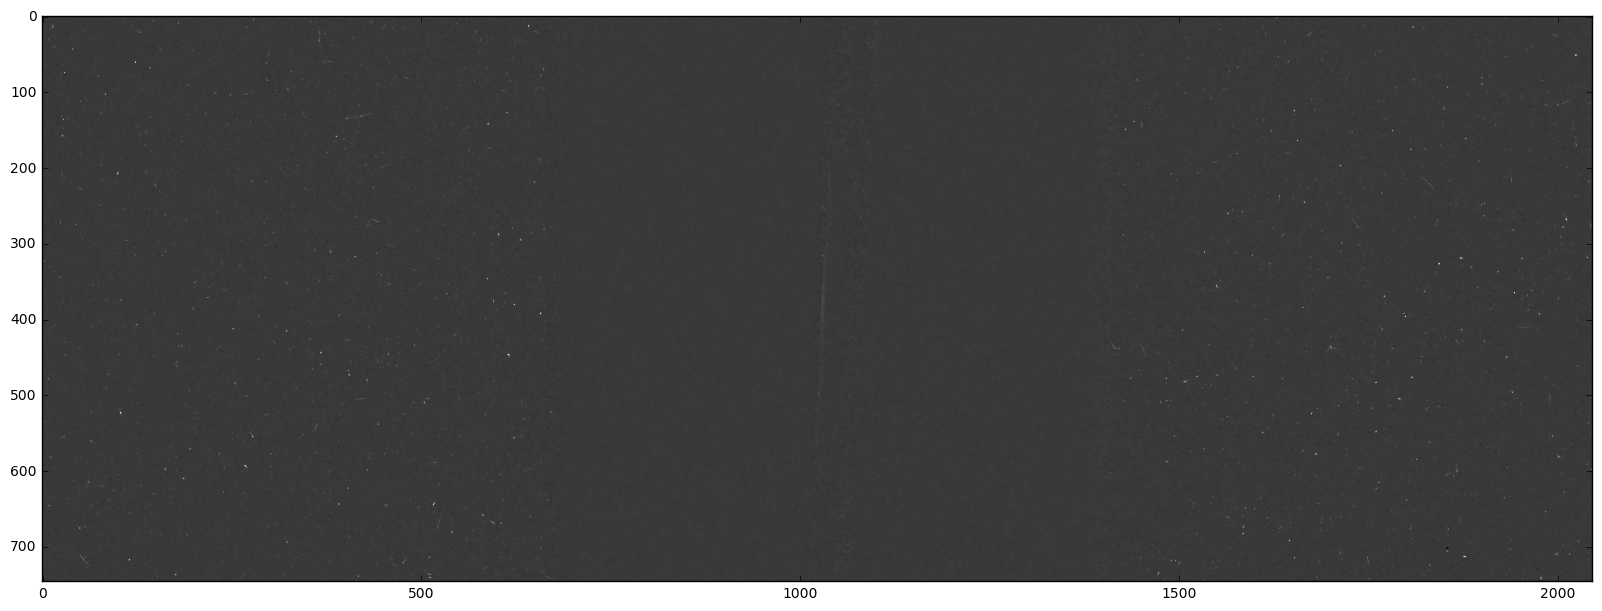

In [21]:
[left, right, top, bottom] = zoom.widget.result

config_handler.save_config(key='norm_zoom_left', value=left)
config_handler.save_config(key='norm_zoom_right', value=right)
config_handler.save_config(key='norm_zoom_top', value=top)
config_handler.save_config(key='norm_zoom_bottom', value=bottom)

def plot_images(file_index):
    
    _norm = normalized_data[file_index]
    
    fig = plt.figure(figsize=(20,20))

    ax_img = plt.subplot(111)
    ax_img.imshow(_norm[top:bottom,left:right],
                 cmap='gray',
                 vmin=min_counts,
                 vmax=max_counts)
    
zoom = interact(plot_images,
                  file_index = widgets.IntSlider(min=0,
                                                max=len(list_data)-1,
                                                step=1,
                                                value=0,
                                                description="File Index"))

# Export Normalized Files

In [ ]:
output_folder = config_handler.load_config(key='output_folder')
output_folder = gui_widgets.gui_dname(dir=output_folder,
                                message='Select The Output Folder ...')
if not output_folder == '':
    config_handler.save_config(key='output_folder', value=output_folder)

 #import images
w = widgets.IntProgress()
w.max = len(list_data)
display(w)

for _index, _norm in enumerate(normalized_data):
    _name = os.path.basename(list_data[_index])
    _new_name = os.path.join(output_folder, _name)
    file_handler.save_tiff(file_name=_new_name, data=_norm)
    
    w.value = _index + 1    